<a href="https://colab.research.google.com/github/voirinprof/python-geo-colab/blob/main/deeplabv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutoriel pour utiliser DeepLabV3 sur une image satellitaire

# Objectifs

* Préparer un jeu de données avec Bing
* Utiliser vos données (échantillons)
* Créer un jeu d'entraînement
* Entraîner le modèle DeepLabV3
* Utiliser le modèle entraîné sur une image


## Configurer l'environnement

Installer rasterio et fiona

In [1]:
!pip install rasterio fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 31.0 MB/s eta 0:00:00


Importer les librairies utiles

In [41]:
import requests
from io import BytesIO
from PIL import Image

import numpy as np
import math
import os
import glob
import random

# fonctionnalités de rasterio
import rasterio
from rasterio.transform import from_bounds
from rasterio.plot import show
from rasterio.features import rasterize

# fonctionalités de fiona
import fiona
from fiona.transform import transform_geom
from pyproj import Transformer

import matplotlib.pyplot as plt

# fonctionnalités pour DeepLabV3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead


## Préparer un jeu de données

On va utiliser des données de Bing. On télécharge quelques tuiles.

In [42]:
# Fonctions de conversion (lat/lon ↔ tuiles)
def latlon_to_tile(lat, lon, zoom):
    lat_rad = math.radians(lat)
    n = 2 ** zoom
    xtile = int((lon + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return xtile, ytile

def tile_to_latlon(xtile, ytile, zoom):
    n = 2 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return lat_deg, lon_deg

def tile_to_quadkey(xtile, ytile, zoom):
    quadkey = ""
    for i in range(zoom, 0, -1):
        digit = 0
        mask = 1 << (i - 1)
        if (xtile & mask) != 0:
            digit += 1
        if (ytile & mask) != 0:
            digit += 2
        quadkey += str(digit)
    return quadkey

# Télécharger une tuile
def download_tile(quadkey):
    serveur = np.random.randint(0, 4)
    url = f"http://ecn.t{serveur}.tiles.virtualearth.net/tiles/a{quadkey}.jpeg?g=854&mkt=en-US"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        raise Exception(f"Erreur {response.status_code} pour {url}")

# Sauvegarder avec géoréférencement
def save_geotiff(tile_img, xtile, ytile, zoom, output_path):
    tile_size = 256  # Taille standard des tuiles Bing

    # Calculer les coins géographiques de la tuile
    lat_north, lon_west = tile_to_latlon(xtile, ytile, zoom)  # Coin supérieur gauche
    lat_south, lon_east = tile_to_latlon(xtile + 1, ytile + 1, zoom)  # Coin inférieur droit

    # Convertir l'image en tableau numpy
    tile_array = np.array(tile_img)

    # Définir la transformation géographique
    transform = from_bounds(lon_west, lat_south, lon_east, lat_north, tile_size, tile_size)

    # Paramètres du GeoTIFF
    profile = {
        'driver': 'GTiff',
        'height': tile_size,
        'width': tile_size,
        'count': 3,  # RGB
        'dtype': rasterio.uint8,
        'crs': 'EPSG:4326',  # WGS84
        'transform': transform,
        'nodata': None
    }

    # Sauvegarder en GeoTIFF
    with rasterio.open(output_path, 'w', **profile) as dst:
        for i in range(3):  # R, G, B
            dst.write(tile_array[:, :, i], i + 1)
    print(f"GeoTIFF sauvegardé : {output_path}")

# Télécharger une zone avec géoréférencement
def download_georeferenced_area(lat_min, lon_min, lat_max, lon_max, zoom, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Calculer les indices de tuiles pour la bounding box
    x_min, y_max = latlon_to_tile(lat_min, lon_min, zoom)  # Bas-gauche
    x_max, y_min = latlon_to_tile(lat_max, lon_max, zoom)  # Haut-droit

    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            quadkey = tile_to_quadkey(x, y, zoom)
            try:
                tile_img = download_tile(quadkey)
                output_path = os.path.join(output_dir, f"tile_{x}_{y}_z{zoom}.tif")
                save_geotiff(tile_img, x, y, zoom, output_path)
            except Exception as e:
                print(f"Erreur pour tuile {x}_{y} : {e}")

On définit une zone d'étude, on devra par la suite fournir des échantillons pour cette même zone

In [45]:
# zone d'étude
lat_min, lon_min = 45.377638, -71.934158
lat_max, lon_max = 45.384081, -71.919561
zoom = 19
output_dir = "/content/bing_geotiles"

# si le répertoire n'existe pas, on va le créer
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Télécharger la zone
download_georeferenced_area(lat_min, lon_min, lat_max, lon_max, zoom, output_dir)

GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187805_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187806_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187807_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187808_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187809_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187810_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187811_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187812_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187813_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187814_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187815_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187816_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187817_z19.tif
GeoTIFF sauvegardé : /content/bing_geotiles/tile_157382_187818_z19.tif
GeoTIF

On compte les images téléchargées

In [46]:
!ls -1 /content/bing_geotiles/ | wc -l

330


On affiche une image

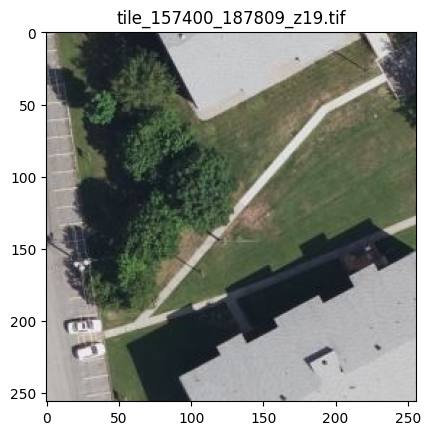

In [49]:
files = glob.glob("/content/bing_geotiles/*.tif")

# Chemin vers le fichier GeoTIFF
geotiff_file = random.choice(files)

# Ouvrir le fichier GeoTIFF avec rasterio
with rasterio.open(geotiff_file) as src:
  # Lire l'image
  image = src.read()

  # ajout d'un titre
  plt.title(os.path.basename(geotiff_file))
  # Afficher l'image avec matplotlib
  show(image)




Si vous voulez créer un image unique avec toutes les tuiles, alors vous pouvez utiliser GDAL

* Créer un fichier texte avec la liste des tuiles
`!find bing_geotiles/ -name "*.tif" > filelist_uds.txt`
* Créer une mosaïque virtuelle
`!gdalbuildvrt -input_file_list filelist_uds.txt mosaic_uds.vrt`



## Créer un jeu d'entraînement

On doit créer un masque pour chaque tuile. Le plus simple est d'utiliser un fichier vectoriel avec des zones définies (les classes recherchées).

On va prendre chaque tuile et on va créer un masque avec des valeurs allant de 0 à 7 (car on a 8 classes). Le fond sera 0.

In [50]:
data_dir = "bing_geotiles/*.tif"

# on liste les tuiles
files = glob.glob(data_dir)

# voici nos classes
allclasses = {
    'bg': 0,
    'trees': 1,
    'grass': 2,
    'pool': 3,
    'parking': 4,
    'building': 5,
    'road': 6,
    'car': 7
}

# si le répertoire masks n'existe pas, on va le créer
if not os.path.exists("masks"):
    os.makedirs("masks")

# on parcourt les tuiles
for file in files:

  geotiff_path = file
  shapefile_path = "/content/training_samples.shp"

  output_raster_path = "masks/" + os.path.basename(file)

  out_crs = "EPSG:3857"
  # on va lire notre fichier vectoriel contenant des polygones avec une étiquette (label)
  with rasterio.open(geotiff_path) as src:

    bounds = src.bounds  # Emprise en EPSG:4326 (left, bottom, right, top)
    meta = src.meta.copy()  # Métadonnées pour le raster de sortie
    transform = src.transform
    width = src.width
    height = src.height

  # le fichier vectoriel n'est pas dans le CRS des tuiles
  transformer_to_out_crs = Transformer.from_crs("EPSG:4326", out_crs, always_xy=True)
  xmin_out_crs, ymin_out_crs = transformer_to_out_crs.transform(bounds.left, bounds.bottom)
  xmax_out_crs, ymax_out_crs = transformer_to_out_crs.transform(bounds.right, bounds.top)
  bounds_out_crs = (xmin_out_crs, ymin_out_crs, xmax_out_crs, ymax_out_crs)

  features = []
  with fiona.open(shapefile_path, "r") as shp:

    # Vérifier le CRS du Shapefile
    shp_crs = shp.crs
    if shp_crs != {'init': f'{out_crs}'}:
      raise ValueError(f"CRS du Shapefile attendu : EPSG:3347, trouvé : {shp_crs}")

    # Filtrer les géométries dans l'emprise en EPSG:3347
    for feature in shp.filter(bbox=bounds_out_crs):
      # Reprojeter chaque géométrie de EPSG:3347 vers EPSG:4326
      geom_4326 = transform_geom(out_crs, "EPSG:4326", feature["geometry"])

      features.append((geom_4326, allclasses[feature["properties"]['label']]))

  # on ne va pas générer de masque si on a aucune géométrie
  if not features:
      #raise ValueError("Aucune géométrie trouvée dans l'emprise du GeoTIFF")
      continue

  print(f"{len(features)} géométries extraites et reprojetées")

  raster_data = rasterize(
        shapes=features,
        out_shape=(height, width),
        transform=transform,
        fill=0,  # Valeur pour les zones non couvertes
        default_value=1,  # Valeur pour les zones couvertes
        dtype=rasterio.uint8
    )

  meta.update({
        "dtype": rasterio.uint8,
        "count": 1,
        "compress": "lzw"
  })

  # Écrire le raster rasterisé
  with rasterio.open(output_raster_path, "w", **meta) as dst:
      dst.write(raster_data, 1)

  print(f"Rasterisation terminée : {output_raster_path}")



1 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157396_187814_z19.tif
1 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157387_187817_z19.tif
2 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157385_187812_z19.tif
1 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157390_187819_z19.tif
1 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157400_187817_z19.tif
5 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157385_187805_z19.tif
5 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157398_187814_z19.tif
4 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157385_187806_z19.tif
3 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157394_187810_z19.tif
5 géométries extraites et reprojetées
Rasterisation terminée : masks/tile_157399_187805_z19.tif
4 géométries extraites et reprojetées
Ra

On compte le nombre de masques créés

In [51]:
!ls -1 /content/masks/ | wc -l

293


On doit avoir au moins 2 classes dans chaque masque. On va vérifier les masques et on va les enlever si ce n'est pas le cas. Ensuite on éliminera les tuiles liées. On doit avoir un masque = une tuile.

In [53]:
files_to_remove = []

# On parcourt les masques
for filename in os.listdir('/content/masks'):
    if filename.endswith('.tif'):  # vérifions l'extension
        filepath = os.path.join('/content/masks', filename)
        try:
            with rasterio.open(filepath) as src:
                # on lit l'image
                raster_data = src.read(1)  # on lit la bande #1

                # on récupère la liste des pixels
                unique_values = np.unique(raster_data)

                # on affiche un message
                print(f"File: {filename}")
                print(f"Unique pixel values: {unique_values}")
                if len(unique_values) < 2:
                  files_to_remove.append(filename)
        except Exception as e:
                print("-" * 20)

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

for file in files_to_remove:
  os.remove(os.path.join('/content/masks', file))


# on ajuste les tuiles en conséquence
for filename in os.listdir('/content/bing_geotiles'):
    if filename.endswith('.tif'):  # vérifions l'extension
        # si le fichier n'existe pas dans /bing_geotiles
        if not os.path.exists(os.path.join('/content/masks', filename)):
          os.remove(os.path.join('/content/bing_geotiles', filename))

# nombre de tuiles et de masques
print(f"Nombre de tuiles : {len(os.listdir('/content/bing_geotiles'))}")
print(f"Nombre de masques : {len(os.listdir('/content/masks'))}")


File: tile_157396_187814_z19.tif
Unique pixel values: [0 5]
File: tile_157387_187817_z19.tif
Unique pixel values: [0 4]
File: tile_157385_187812_z19.tif
Unique pixel values: [0 2 6]
File: tile_157390_187819_z19.tif
Unique pixel values: [0 6]
File: tile_157385_187805_z19.tif
Unique pixel values: [0 5 6]
File: tile_157398_187814_z19.tif
Unique pixel values: [0 5 6]
File: tile_157385_187806_z19.tif
Unique pixel values: [0 5 6]
File: tile_157394_187810_z19.tif
Unique pixel values: [0 5 6]
File: tile_157399_187805_z19.tif
Unique pixel values: [0 5]
File: tile_157385_187814_z19.tif
Unique pixel values: [0 5 6]
File: tile_157399_187817_z19.tif
Unique pixel values: [0 1]
File: tile_157387_187808_z19.tif
Unique pixel values: [0 5 6]
File: tile_157390_187813_z19.tif
Unique pixel values: [0 5 6]
File: tile_157383_187809_z19.tif
Unique pixel values: [0 5 6]
File: tile_157384_187809_z19.tif
Unique pixel values: [0 5 6]
File: tile_157386_187807_z19.tif
Unique pixel values: [0 5]
File: tile_157390_18

## Entraîner le modèle

On va utiliser le jeu d'entraînement et exécuter l'apprentissage de DeepLabV3.

In [54]:
# Définir la classe Dataset personnalisée
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))  # Liste des fichiers images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")  # Charger l'image en RGB
        mask = Image.open(mask_path)  # Charger le masque (valeurs entières : 0, 1, 2, ...)

        if self.transform:
            image = self.transform(image)
            mask = transforms.ToTensor()(mask) * 255  # Convertir en tensor et remettre à l'échelle
            mask = mask.squeeze().long()  # Enlever la dimension inutile et passer en LongTensor

        return image, mask

# Définir les transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionner à 512x512
    transforms.ToTensor(),          # Convertir en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
])

# Charger les données (1 tuile = 1 masque)
train_dataset = CustomSegmentationDataset(
    image_dir="/content/bing_geotiles",
    mask_dir="/content/masks",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)  # Batch de 4

# Charger et modifier DeepLabV3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)

# Modifier la tête pour vos classes (ex. : 8 classes : fond, végétation, bâtiments, routes, ...)
num_classes = 8
model.classifier = DeepLabHead(2048, num_classes)
model = model.to(device)

# Définir la perte et l’optimiseur
criterion = nn.CrossEntropyLoss()  # Perte pour segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimiseur Adam

# Boucle d’entraînement
num_epochs = 10  # Nombre d’époques
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Passe avant
        outputs = model(images)['out']  # Prédictions du modèle
        loss = criterion(outputs, masks)

        # Passe arrière et optimisation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 9:  # Afficher toutes les 10 itérations
            print(f"Époque {epoch+1}, Batch {i+1}/{len(train_loader)}, Perte : {running_loss/10:.4f}")
            running_loss = 0.0

    print(f"Époque {epoch+1}/{num_epochs} terminée.")

# Sauvegarder le modèle entraîné
torch.save(model.state_dict(), "deeplabv3_sivu.pth")
print("Modèle sauvegardé sous 'deeplabv3_sivu.pth'.")

Époque 1, Batch 10/72, Perte : 1.8248
Époque 1, Batch 20/72, Perte : 0.9880
Époque 1, Batch 30/72, Perte : 0.9751
Époque 1, Batch 40/72, Perte : 0.8430
Époque 1, Batch 50/72, Perte : 0.7096
Époque 1, Batch 60/72, Perte : 0.6920
Époque 1, Batch 70/72, Perte : 0.7847
Époque 1/10 terminée.
Époque 2, Batch 10/72, Perte : 0.7116
Époque 2, Batch 20/72, Perte : 0.6926
Époque 2, Batch 30/72, Perte : 0.7776
Époque 2, Batch 40/72, Perte : 0.6334
Époque 2, Batch 50/72, Perte : 0.6909
Époque 2, Batch 60/72, Perte : 0.6745
Époque 2, Batch 70/72, Perte : 0.6268
Époque 2/10 terminée.
Époque 3, Batch 10/72, Perte : 0.6198
Époque 3, Batch 20/72, Perte : 0.5568
Époque 3, Batch 30/72, Perte : 0.6230
Époque 3, Batch 40/72, Perte : 0.6484
Époque 3, Batch 50/72, Perte : 0.7122
Époque 3, Batch 60/72, Perte : 0.5430
Époque 3, Batch 70/72, Perte : 0.6554
Époque 3/10 terminée.
Époque 4, Batch 10/72, Perte : 0.5848
Époque 4, Batch 20/72, Perte : 0.7251
Époque 4, Batch 30/72, Perte : 0.5638
Époque 4, Batch 40/72,

## Utiliser le modèle entraîné

On utilise le modèle sauvegardé et on l'applique sur une image

In [55]:
# Définir le dispositif (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recréer le modèle avec la même architecture
num_classes = 8
model = deeplabv3_resnet101(weights=None, aux_loss=True)  # Pas de poids pré-entraînés par défaut
model.classifier = DeepLabHead(2048, num_classes)
model = model.to(device)

# Charger les poids sauvegardés
model.load_state_dict(torch.load("/content/deeplabv3_sivu.pth", map_location=device))
model.eval()  # Passer en mode évaluation (pas d’entraînement)

# Définir les transformations (identiques à l’entraînement)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Taille utilisée lors de l’entraînement
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
])


image_path = r"/content/bing_geotiles/tile_157384_187819_z19.tif"
# Charger  l’image

with rasterio.open(image_path) as src:
    bounds = src.bounds  # Emprise en EPSG:4326 (left, bottom, right, top)
    meta = src.meta.copy()  # Métadonnées pour le raster de sortie
    geotransform = src.transform
    width = src.width
    height = src.height
    crs = src.crs

image = Image.open(image_path).convert("RGB")  # Charger en RGB
input_tensor = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension batch

# Effectuer l’inférence
with torch.no_grad():  # Pas de calcul de gradients
    output = model(input_tensor)['out']  # Prédiction
    pred = output.argmax(dim=1).cpu().numpy()[0]  # Classe prédite pour chaque pixel

    pred_image = Image.fromarray((pred * 255 / (num_classes - 1)).astype(np.uint8))  # Remettre à l’échelle si besoin
    output_path = f"/content/{os.path.basename(image_path).replace('.tif', '_pred.tif')}"
    with rasterio.open(output_path, 'w', driver='GTiff',
        height=height,
        width=width,
        count=1,  # 1 bande pour la segmentation
        dtype=np.uint8,  # Type de données
        crs=crs,  # Système de coordonnées
        transform=geotransform  # Transformation géospatiale) as dst:
    ) as dst:
        dst.write(pred, 1)

<ipython-input-56-462384ce168a>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', np.max(image2) + 1)  # Adjust number of colors if needed
<ipython-input-56-462384ce168a>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', np.max(image3) + 1)  # Adjust number of colors if needed


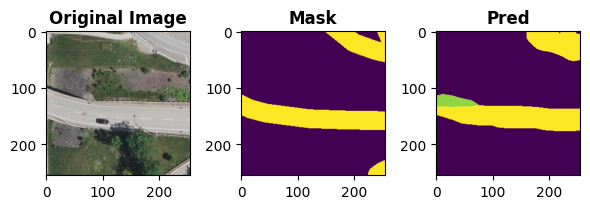

In [56]:
# Assuming geotiff_file and output_path are defined from previous code

tile = 'tile_157384_187819_z19'

geotiff_file = f"/content/bing_geotiles/{tile}.tif"
mask_file = f"/content/masks/{tile}.tif"
output_path = f"/content/{tile}_pred.tif"

fig, axes = plt.subplots(1, 3, figsize=(6, 6))

with rasterio.open(geotiff_file) as src:
    image1 = src.read()
    show(image1, ax=axes[0], title="Original Image")

with rasterio.open(mask_file) as src:
    image2 = src.read()

    # Apply random colors to image2 (example using a random colormap)
    cmap = plt.cm.get_cmap('viridis', np.max(image2) + 1)  # Adjust number of colors if needed
    show(image2, ax=axes[1], cmap=cmap, title="Mask")

with rasterio.open(output_path) as src:
    image3 = src.read()

    # Apply random colors to image2 (example using a random colormap)
    cmap = plt.cm.get_cmap('viridis', np.max(image3) + 1)  # Adjust number of colors if needed
    show(image3, ax=axes[2], cmap=cmap, title="Pred")

plt.tight_layout()
plt.show()
